# Identify Factors that Predict Intro CS Experience Based on Gender: Part Two


### Problem Statement
I am interested in identify the leading indicators of experience broken down by gender in introductory CS at an elite research university like Berkeley. In short, I want to find the attributes that split the dataset as *purely* as possible into male and female.

To solve this problem, I will undertake the following course of action:
1. Explore the dataset
    - Usually, I would explore the dataset to ensure its integrity and understand the context. But in this case, I will skip this step since I designed the study and collected the data, as such, I am well versed of the context. Further, I have done previous work on this dataset, so I know its boundaries.
2. Identify features that may be used. 
    - If possible, engineer features that might provide greater discrimination.
3. With the understanding that this a `classification` task, explore a couple of classifiers that might be well suited for the problem at hand.
    - Random Forest classifier
    - eXtreme Gradient Boosted (XGBoost) trees classifier
    - Support Vector Machine (SVM)
    - Decision Tree classifier
4.  Select appropriate classifier based on evaluation metric and tune it for optimality.
5.  Extract top features responsible for discriminating the data.

I have already completed steps one and two in this [notebook](https://github.com/omoju/genderCSExperience/blob/master/genderedCSExperience.ipynb). Now I will focus on steps three and four.


## Preliminaries

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Import libraries
from __future__ import division
import sys
sys.path.append('tools/')

import numpy as np
import pandas as pd
import pickle
import tools

   
# Graphing Libraries
import matplotlib.pyplot as pyplt
import seaborn as sns
sns.set_style("white")    

## Load Data

In [3]:
X = pd.read_pickle('data/features.pickle.dat')
y = pd.read_pickle('data/labels.pickle.dat')

In [4]:
# First, decide how many training vs test samples you want
num_all = X.shape[0]  # same as len(student_data)
num_train = 662  # about 75% of the data
num_test = num_all - num_train

In [5]:
from sklearn import cross_validation
def shuffle_split_data(X, y):
    """ Shuffles and splits data into 75% training and 25% testing subsets,
        then returns the training and testing subsets. """
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, 
                                                                        train_size=num_train, random_state=42)
    
    # Return the training and testing data subsets
    return X_train, y_train, X_test, y_test

In [6]:
# Split the data into training and testing sets

try:
    X_train, y_train, X_test, y_test = shuffle_split_data(X, y)
    print "Successfully shuffled and split the data!"
except:
    print "Something went wrong with shuffling and splitting the data."


print "Training set: {} samples".format(X_train.shape[0])
print "Test set: {} samples".format(X_test.shape[0])


Successfully shuffled and split the data!
Training set: 662 samples
Test set: 220 samples


## 3. Modeling and Validating

### Algorithms and Techniques

For the problem of determining the factors that predict intro CS experience based on gender, I experimented with four different classifiers, a decision tree classifier, two ensemble methods and a support vector machine:

- I selected a **Random Forest classifier** because it is considered one of the best off-the-shelf learning algorithm, and requires almost no tuning. 

- I selected an **eXtreme Gradient Boosted (XGBoost) trees classifier**; which is an advanced implementation of the gradient boosting algorithm. From reading literature on machine learning in practice, the XGBoost classifier has differentiated itself as a classifier that has successfully demonstrated its performance in a wide range of problems. For example, "among the 29 challenge winning solutions published at Kaggle's blog during 2015, 17 solutions used XGBoost."

- I selected a **Support Vector Machine (SVMs)** because they are very robust classifiers and *more importantly*, they have a method to correct for class imbalances. 
              
- Finally I selected a **Decision Tree classifier** because it lends itself to interpretability. For this problem domain, it is not just satisfactory for me to discriminate between male and female students, what I ultimately want is to gain *insights* into what the salient factors around the experience of intro CS are, based on gender.


In [7]:
X = X_train # Training data
seed = 342 # For reproducability
folds = 10

In [8]:
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.cross_validation import StratifiedKFold
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn import metrics


models = {
          'XGBoost': XGBClassifier(),
          'DecisionTree': DecisionTreeClassifier(),
          'SVC': svm.SVC(),
          'RandomForest': RandomForestClassifier()
         }


In [9]:
for model_name, model in models.iteritems():
    print model_name
    kfold = StratifiedKFold(y_train, n_folds=folds, random_state=np.random.seed(seed))
    results = cross_val_score(model, X, y_train, cv=kfold, scoring='f1')
    print("Training data score: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100)), '\n'
    
   

RandomForest
Training data score: 50.64% (6.83%) 

DecisionTree
Training data score: 49.26% (8.84%) 

XGBoost
Training data score: 61.73% (6.33%) 

SVC
Training data score: 55.16% (8.36%) 



### Predict 

RandomForest
F1 score: 54.64%


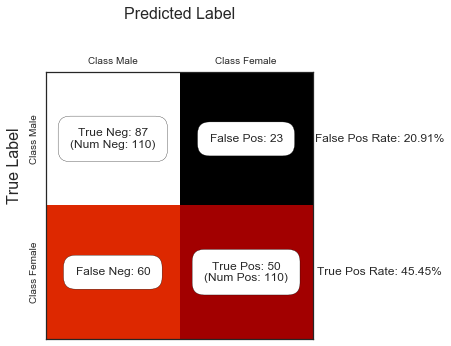

DecisionTree
F1 score: 60.79%


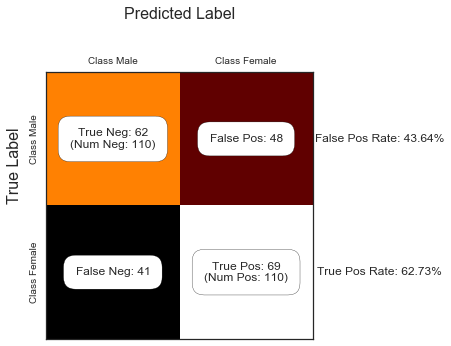

XGBoost
F1 score: 68.37%


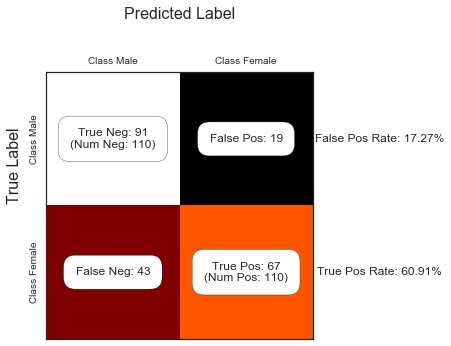

SVC
F1 score: 54.12%


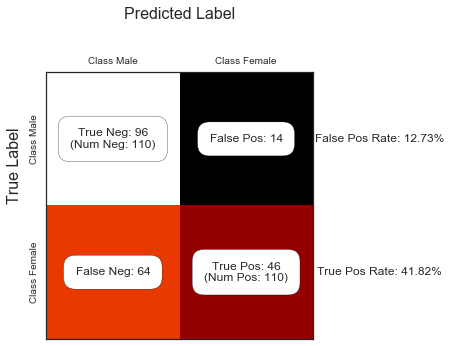

In [10]:
Features_test = X_test
xgb_base_prediction_score = 0


for model_name, model in models.iteritems():
    print model_name
    # make predictions for test data
    model.fit(X, y_train)
    y_predictions = model.predict(Features_test)
    predictions = [round(value) for value in y_predictions]
    # evaluate predictions
    
    print "F1 score: %.2f%%"% (metrics.f1_score(y_test, predictions) * 100)
    if model_name == 'XGBoost':
        xgb_base_prediction_score = metrics.f1_score(y_test, predictions) * 100
    
    C = confusion_matrix(y_test, predictions)
    tools.show_confusion_matrix(C, 'report/figures/'+model_name+'.png', ['Class Male', 'Class Female'])

## 4. Select XGBoost classifier

From running these baseline classifiers, I selected the xgboost classifier because it had the highest score. In addition, when I looked at the result of the confusion matrix, I decided to use the lowest **false negative** count for the female class as my evaluation metric. From the images, the *Decision Tree* and the *XGBoost*, I can see that the decision tree and xgboost learners are tied for having the lowest score of false negatives for the female class.

This is a good time to take a break and look over the initial steps to the solution.
#### Solution steps
1. Explore the dataset
2. Identify features that may be used. 
3. Explore a couple of classifiers that might be well suited for the problem at hand.
    - Random Forest classifier
    - eXtreme Gradient Boosted (XGBoost) trees classifier
    - Support Vector Machine (SVM)
    - Decision Tree classifier
4. Select appropriate classifier based on evaluation metric and tune it for optimality.
5. Extract top features responsible for discriminating the data.

I will expand the final step:
    - Explore the various parameters around feature splitting 
        - Xgboost algorithm feature importance score
        - Information gain
        - Cover

### Feature Importance: Xgboost Base Model
There are two things that need consideration when using xgBoost for understanding feature importance: the features that are doing the *most* work in splitting the data, and the automatically generated feature importance ranking that is done in xgBoost.



In [11]:
model = XGBClassifier()
model.fit(X, y_train)
    
    
g = xgb.to_graphviz(model, num_trees=1, rankdir='TB')
g.format = 'png'
g.render('report/figures/firstXGraph', view=False)
g = xgb.to_graphviz(model, num_trees=2, rankdir='TB')
g.format = 'png'
g.render('report/figures/SecondXGraph', view=False)

'report/figures/SecondXGraph.png'


I plotted some estimators in the xgboost learners to see which features are doing the most work in splitting the data. I chose to focus on the **first** and **second** tree in the ensemble. On simple models, the first two trees may be enough to gain a *strong* understanding.

| **First tree in the ensemble** | **Second tree in the ensemble** |
|---|---|
| <img src="report/figures/firstXGraph.png" alt="Drawing" style="width: 500px;"/>  | <img src="report/figures/secondXGraph.png" alt="Drawing" style="width: 500px;"/> |


|Coded item|Description|
|---|---|
|atcsgender_2|Women are smarter than men.|
|atcsjobs_2|My career goals do not require that I learn computing skills. |
|clet_2|I think about the ethical, legal, and social implications of computing.|
|atct_6|I am good at building things.|
|prepared|How prepared did you feel about this class before it started?|
|atcsjob_1|Knowledge of computing will allow me to secure a good job.|
|clet_1|I work well in teams.|
|atct_7|I am good at ignoring irrelevant details to solve a problem.|
|blg_1|In this class, I feel I belong.|
|atct_3|I am good at using online search tools.|| 




In [12]:
tools.dataLookUp('atcsgender_1')

Women are less capable of success in CS than men.


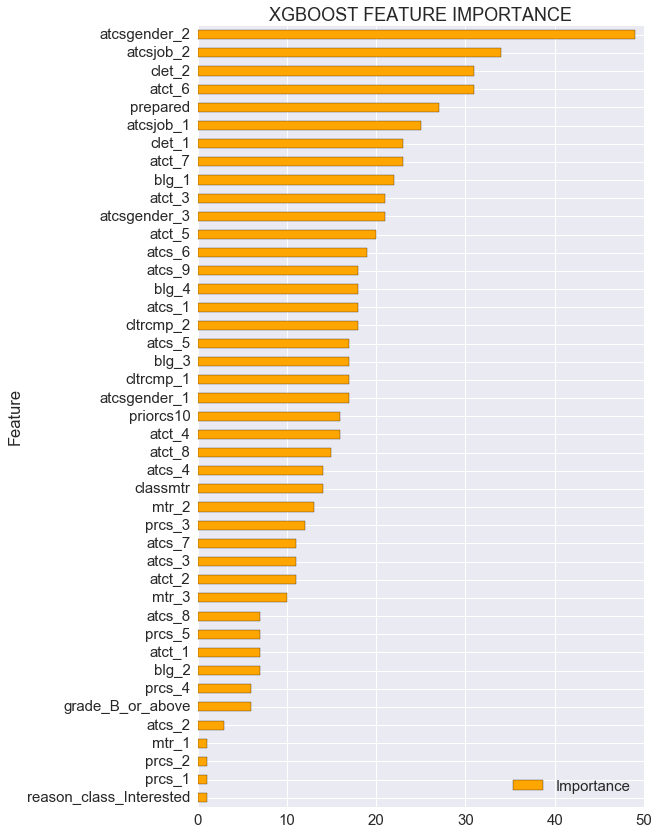

In [13]:
sns.set(font_scale = 1.5)

importances = model.booster().get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14),  color = 'orange');
pyplt.title('XGBOOST FEATURE IMPORTANCE')
pyplt.savefig('report/figures/featureImportance.png', dpi=200, bbox_inches='tight')


## 4. Tune Xgboost Model

I am going to tune my model based on some heuristics about the kinds of value ranges that are suitable for the hyper-parameters I want to learn.

#### Ideal choices of parameters as taken from Xgboost With Python ebook
- Number of Trees (`n_estimators`) set to a fixed value between 100 and 1000, depending on the dataset size.
- Learning Rate (`learnin_rate`) simplified to the ratio: [2 to 10]/trees, depending on the trees number of trees.
- Row Sampling (`subsample`) grid searched values in the range [0.5, 0.75, 1.0].
- Column Sampling (`colsample` bytree and maybe colsample bylevel) grid searched values in the range [0.4, 0.6, 0.8, 1.0].
- Min Leaf Weight (`min_child_weight`) simplified to the ratio 3/rare_events , where rare events rare events is the percentage of rare event observations in the dataset.
- Tree Size (`max_depth`) grid searched values in the rage [4, 6, 8, 10].
- Min Split Gain (`gamma`) fixed with a value of zero.


In [14]:
from sklearn.grid_search import GridSearchCV



# Build a stratified shuffle object because of unbalanced data
ssscv = StratifiedShuffleSplit(y_train, folds, random_state=np.random.seed(seed))

params_grid = {
            'learning_rate': [0.2222, 0.4444, 0.6666, 0.8888],
            'max_depth': [4],
            'n_estimators': range(100, 1100, 100),
            'colsample_bytree': [0.4, 0.6, 0.8, 1.0],
            'subsample':[0.7]
}

params_fixed = {
    'objective': 'binary:logistic',
    'silent': 1
}

In [15]:
# Load and use already tuned classifier, else tune classifier

tune_flag = False
model_filename = "data/fixedDepthTree.pickle.dat"

if tune_flag:
    grid = GridSearchCV(estimator=XGBClassifier(**params_fixed),
        param_grid=params_grid,
        cv=ssscv,
        scoring='f1')
    grid.fit(X, y_train)
    
    print "Best accuracy obtained: {0}".format(grid.best_score_)
    print "Parameters:"
    for key, value in grid.best_params_.items():
        print "\t{}: {}".format(key, value)
    model = grid.best_estimator_
    
    # save model to file
    pickle.dump(model, open(model_filename, "wb"))
    
else:    
    model = tools.load_model(model_filename)
    print model.get_params()
    

{'reg_alpha': 0, 'colsample_bytree': 0.6, 'silent': 1, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.4444, 'missing': nan, 'max_delta_step': 0, 'nthread': -1, 'base_score': 0.5, 'n_estimators': 700, 'subsample': 0.7, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'binary:logistic', 'max_depth': 4, 'gamma': 0}


In [16]:
Features_test = X_test

# make predictions for test data
model.fit(X, y_train)
ypred = model.predict(Features_test)
predictions = ypred

# evaluate predictions
xgb_tuned_prediction_score = f1_score(y_test, predictions) * 100
print "F1 score: %.2f%%"% (xgb_tuned_prediction_score)

print "Model improvement: %.2f%%"% (xgb_tuned_prediction_score - xgb_base_prediction_score)

F1 score: 71.22%
Model improvement: 2.85%


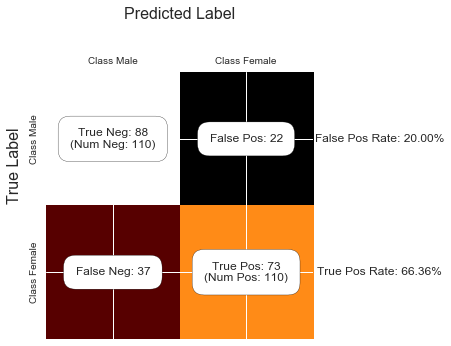

In [17]:
sns.set(font_scale = 1)

C = confusion_matrix(y_test, ypred)
tools.show_confusion_matrix(C, 'report/figures/tuned_model_CM.png', ['Class Male', 'Class Female'])

In [18]:
model.fit(X, y_train)
g = xgb.to_graphviz(model, num_trees=1, rankdir='TB')
g.format = 'png'
g.render('report/figures/first_tuned_model_graph', view=False)

g = xgb.to_graphviz(model, num_trees=2, rankdir='TB')
g.format = 'png'
g.render('report/figures/second_tuned_model_graph', view=False)

'report/figures/second_tuned_model_graph.png'

### Results of tuning
Once I performed the search through the hyper-parameter space to find the combination of hyper-parameters that maximized the performance of the selected classifier, I was able to **improve** the previous `F_1` score **by 2.85%**, to achieve a prediction score of 71.22%.
- You can see that the **false negative** count for the female class has gone from 43 down to 37. This decision cost us a very small increase in the **false positive** count of the male class from 19 to 22. This is not too bad, so I will stick with this improved model.

| **Base Model** | **Tuned Model** |
|---|---|
| <img src="report/figures/XGBoost.png" alt="Drawing" style="width: 350px;"/>  | <img src="report/figures/tuned_model_CM.png" alt="Drawing" style="width: 350px;"/> |

The tuned model has a very complex tree that goes down ten levels, for each of its estimators. This model segmented the data into 14 distinct types; you can see this by counting the number of leaf nodes.

#### First tree in the esemble
![tuned tree](report/figures/first_tuned_model_graph.png)


#### Second tree in the esemble
![tuned tree](report/figures/second_tuned_model_graph.png)

## 5(a). Feature Importance: Tuned Model

In [19]:
params_dict = model.get_params()
xgdmat = xgb.DMatrix(X, y_train) # Create our DMatrix to make XGBoost more efficient
testdmat = xgb.DMatrix(X_test)

cv_xgb = xgb.cv(params = params_dict, dtrain = xgdmat, num_boost_round = 3000, nfold = folds,
                metrics =['map'],
                early_stopping_rounds = 100) # Look for early stopping that minimizes error


Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration: 13


In [20]:
bst = xgb.train(params_dict, xgdmat, num_boost_round = 13)
y_pred = bst.predict(testdmat,ntree_limit=bst.best_ntree_limit)

In [21]:
# evaluate predictions
y_pred[y_pred > 0.5] = 1
y_pred[y_pred <= 0.5] = 0
print "F1 score: %.2f%%"% (f1_score(y_test, y_pred) * 100)

F1 score: 71.70%


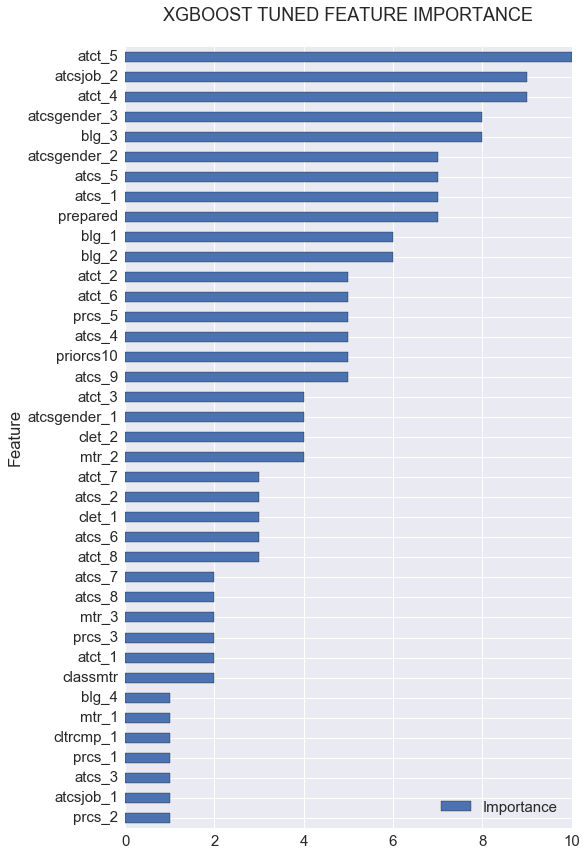

In [22]:
sns.set(font_scale = 1.5)

importances = bst.get_fscore()
importance_frame = pd.DataFrame({'Importance': list(importances.values()), 'Feature': list(importances.keys())})
importance_frame.sort_values(by = 'Importance', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14));
pyplt.title('XGBOOST TUNED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_tuned.png', dpi=200, bbox_inches='tight')


## 5(b). Feature Importance: Information Gain based Ranking 
One can think on **information gain** as a measurement of *informativeness* of a feature with respect to the target class.

In [23]:
tools.create_feature_map(list(importances.keys()),'xgb_model_feature_map.txt')

In [24]:
information_gain_list = tools.order_features_by_gains(bst, 'xgb_model_feature_map.txt')

In [25]:
info_importances = {}
for i in range(len(information_gain_list)):
    feat, info = information_gain_list[i]
    info_importances[feat] = round(info['gain'])
    

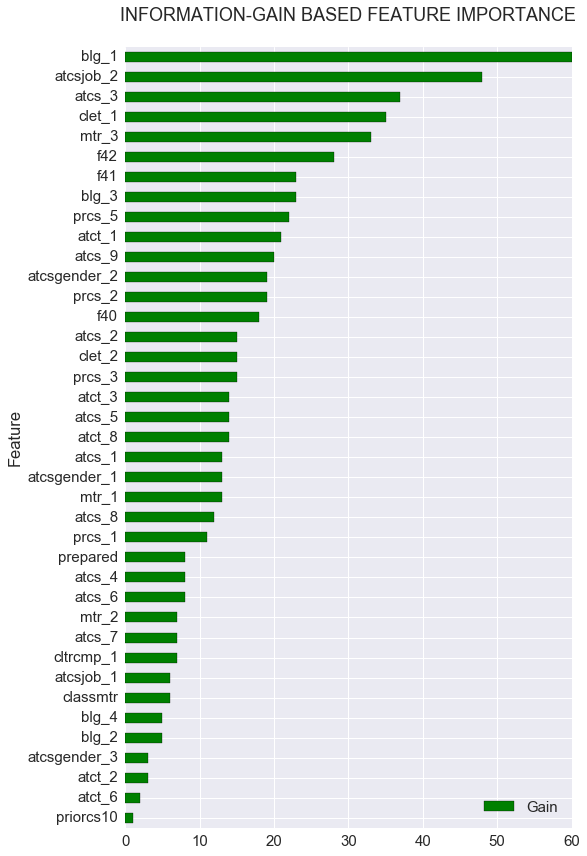

In [26]:
sns.set(font_scale = 1.5)
importance_frame = pd.DataFrame({'Gain': list(info_importances.values()), 'Feature': list(info_importances.keys())})
importance_frame.sort_values(by = 'Gain', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14), color = 'green');
pyplt.title('INFORMATION-GAIN BASED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_informationGain.png', dpi=200, bbox_inches='tight')


## 5(c). Feature Importance: Cover based Ranking 

The cover is the sum of second order gradient in each node, and intuitively it represents the number of data points affected by the split.

In [27]:
info_importances = {}
for i in range(len(information_gain_list)):
    feat, info = information_gain_list[i]
    info_importances[feat] = round(info['cover'])


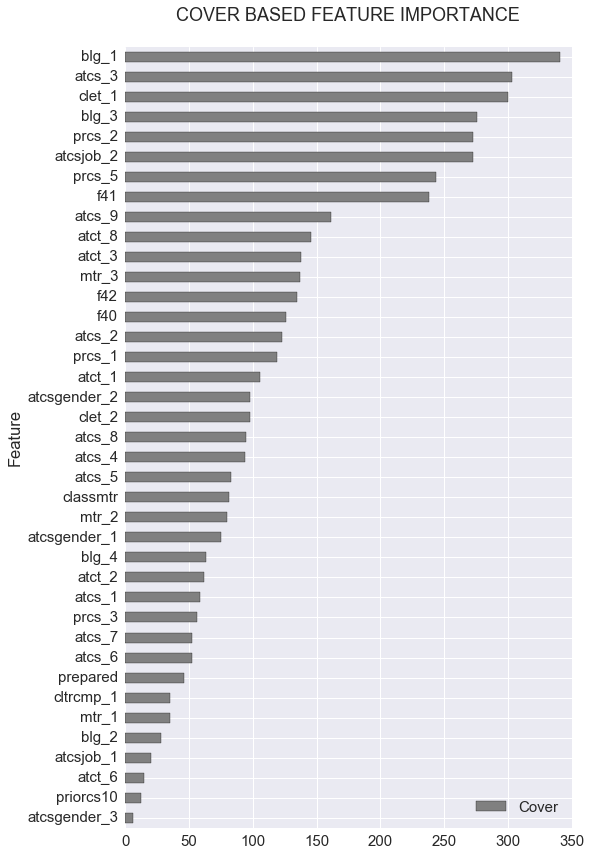

In [28]:
sns.set(font_scale = 1.5)
importances = bst.get_fscore()
importance_frame = pd.DataFrame({'Cover': list(info_importances.values()), 'Feature': list(info_importances.keys())})
importance_frame.sort_values(by = 'Cover', inplace = True)
importance_frame.plot(kind = 'barh', x = 'Feature', figsize = (8,14), color = 'grey');
pyplt.title('COVER BASED FEATURE IMPORTANCE\n')
pyplt.savefig('report/figures/featureImportance_cover.png', dpi=200, bbox_inches='tight')
